In [1]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt

def plot(values, edges, **kwargs):
    return plt.plot(edges, np.append(values, np.nan), drawstyle="steps-post", **kwargs)

## Axis types

Boost-Histogram offers you many interesting axis types. There are so called *continuous axes* which have bins that are intervals over the real line. And there are so called *discrete axes*, which have bins that represent a single value. The latter are further subdivided into *ordered* and *unordered* axes.

Furthermore, all axes can optionally grow with their input.

### Continuous axes

Type     | Description                     | Performance
-------- | :------------------------------ | :----------
Regular  | Bins of equal width, extendible with value transforms | Fast
Variable | Bins of variable width | Medium

There is not much to say about the `Variable` axis, but let's talk a bit about the `Regular` one.

The `Regular` axis is very performant, so we want to use it often. In HEP, we often logarithmic binning, which has equal width in log-space. The `Regular` axis supports transforms for this use case, which can do log-transforms and more.

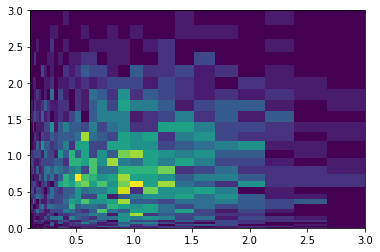

In [2]:
rng = np.random.default_rng(1)

h = bh.Histogram(bh.axis.Regular(30, 0.1, 3, transform=bh.axis.transform.log),
                 bh.axis.Regular(30, 0, 3, transform=bh.axis.transform.sqrt))

x = rng.normal(size=10_000)
y = rng.normal(size=10_000)

h.fill(x, y)

plt.pcolormesh(h.axes[0].edges, h.axes[1].edges, h.view().T);

Square-root binning is similar in effect to log-binning: the bin width grows with the values. Both are suitable for power-law distributed data. The square-root binning has the advantage, that the lowest bin may include 0.

Both the regular and the variable axis also support circular axes, that wrap around at the end. With such an axis, there is no need to remember whether your angles were normalized to $[0, 2\pi)$ or $[-\pi, \pi)$, or normalized at all.

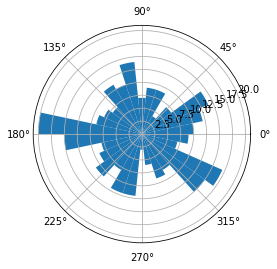

In [3]:
h = bh.Histogram(bh.axis.Regular(30, 0, 2*np.pi, circular=True))

h.fill(np.random.uniform(-np.pi, np.pi, size=300)) # has "wrong" format, but works anyway

ax = plt.subplot(111, polar=True)

plt.bar(*h.axes.centers, h, width=h.axes.widths[0]);

#### Write your own transforms!

You can even write your own transformations with numba, see the Boost-Histogram documentation.

### Discrete axes

Type     | Description                    | Performance
-------- | :----------------------------- | :----------
Integer  | Ordered contiguous range of integers | Very fast
Boolean  | Two bins: False, True | Very fast
IntCategory | Unordered integer values (e.g. PDG ids) | Fast for small numbers
StrCategory | Unordered string values | Like IntCategory, but slower due to string comparison

Discrete axes are useful when you have discrete data, naturally, and furthermore to organise variations of your data.

A histogram in your analysis may look like this:

In [4]:
nicely_organised = bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                                bh.axis.Regular(5, 0, 5, metadata="eta"),
                                bh.axis.Boolean(metadata="is simulation"),
                                bh.axis.Boolean(metadata="is candidate"))

which is arguably better organised than the equivalent:

In [5]:
not_so_nicely_organised = {
    ("data", "non-candidates"): 
        bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                     bh.axis.Regular(5, 0, 5, metadata="eta")),                
    ("data", "candidates"):
        bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                     bh.axis.Regular(5, 0, 5, metadata="eta")),                
    ("simulation", "non-candidates"):
        bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                     bh.axis.Regular(5, 0, 5, metadata="eta")),                
    ("simulation", "candidates"):
        bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                     bh.axis.Regular(5, 0, 5, metadata="eta")),
}

Using `Boolean` axes **gives you the combinatorics for free**, and you can easily project to supersets. For example, to get all tracks, whether they are candidates or not.

In [6]:
all_tracks = nicely_organised.project(0, 1, 3)

The `IntCategory` is very useful to keep track of different particles in the simulation, and to keep track of data from different runs of the experiment (which you may want to analyse separately for systematic studies).

In [7]:
from particle import literals as lp

# for simulated data, you might want to use
h = bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                 bh.axis.Regular(5, 0, 5, metadata="eta"),
                 bh.axis.IntCategory([lp.pi_plus, lp.pi_minus, lp.proton, lp.antiproton]))

# for data, you may want to use this ...
h = bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                 bh.axis.Regular(5, 0, 5, metadata="eta"),
                 bh.axis.Integer(2004, 2010, metadata="years of data taking"))

# ... or this
h = bh.Histogram(bh.axis.Regular(10, 0, 10, metadata="p_T"),
                 bh.axis.Regular(5, 0, 5, metadata="eta"),
                 bh.axis.IntCategory([3976, 3986, 4201], metadata="LHC fill"))

## Generalized histograms and Accumulators

Boost-Histogram offers more than ordinary histograms, it is a generalized histogram library that supports many so-called binned statistics.

These binned statistics are represented by accumulators. These are classes that accept samples and compute something from them. For example, the arithmetic mean:

In [8]:
mean = bh.accumulators.Mean()
mean.fill([.3, .4, .5])

Mean(count=3, value=0.4, variance=0.01)

Interesting properties of the accumulator can be accessed as attributes.

In [9]:
print(f"mean.count={mean.count} mean.value={mean.value:g} mean.variance={mean.variance:g}")

# Python 3.8:
# print(f"{mean.count=} {mean.value=} {mean.variance=}")

mean.count=3.0 mean.value=0.4 mean.variance=0.01


Here are the other currently supported accumulators. The list is growing and more suggestions from users are welcome!

Accumulator | Description | Attributes
----------- | :----------- | :-----------
Mean        | Computes the arithematic mean of samples | count, value, variance
WeightedMean | Computes the mean of weighted samples | sum_of_weights, sum_of_weights_squared, value, variance
Sum         | Computes sum of real weights more accurately | value
WeightedSum | Like Sum, but also keeps track of weight variance | value, variance

Most of these should be pretty clear, but let's talk a bit about computing sums on a computer.

### Spotlight: the Sum accumulator

Why we have a special accumulator for computing sums is best demonstrated in action.

In [11]:
# summing floats that differ a lot in magnitude leads to roundoff errors
values = [1e100, 1, -1e100]

print(f"np.sum             : {np.sum(values)}") 

# Sum accumulator keeps track of these round-off errors
s = bh.accumulators.Sum()
s.fill(values)
print(f"bh.accumulators.Sum: {s.value}")

np.sum             : 0.0
bh.accumulators.Sum: 1.0


The Sum accumulator produces the correct result, while `np.sum` does not. This is not a failure of `np.sum`, it is just how arithmetic with floating point numbers on a computer work.

In [12]:
1e16 + 1 == 1e16

True

The Sum accumulator uses a special algorithm (the [Kahan-Babuška-Neumeier algorithm](https://en.wikipedia.org/wiki/Kahan_summation_algorithm)) to compensate for this loss in precision at the cost of doing 4x as many computations and using 2x as much memory compared to ordinary summation. Because of the performance penalty, it is not used by default.

As a general rule, in Boost-Histogram we give you **choices and reasonable defaults** . If you need extra accuracy, use `Sum`. By default, you get normal summation, which is less precise but more performant.

## Switching the histogram storage

While you can import and use accumulators directly, the intended use of them is in your *histogram storage*. The storage of a histogram holds the accumulators, one per cell. The storage is also responsible for the memory management of its cells and concurrect access, as we will see later.

A remark about jargon:
* **Bin**: discrete unit of a single axis (an interval for a continuous axis, a value for a discrete axis)
* **Cell**: discrete unit in the histogram addressed by the joined bin coordinates

![](histogram_layout.svg)

### Spotlight: profiles

Let's make a 1D histogram with Mean accumulators in each cell. This gives us something analog to what ROOT calls a [TProfile](https://root.cern/doc/v620/classTProfile.html).

In [13]:
profile = bh.Histogram(bh.axis.Regular(10, 0, 1), storage=bh.storage.Mean())

A profile is useful to summarize a trend in some values $y$ that depend on other values $x$, and the $y$ are scattering.

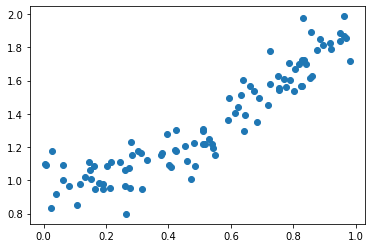

In [14]:
rng = np.random.default_rng(1)
x = rng.uniform(size=100)
ye = 0.1
y = rng.normal(1 + x ** 2, ye)

plt.scatter(x, y);

In [15]:
profile.fill(x, sample=y)

Histogram(Regular(10, 0, 1), storage=Mean()) # Sum: Mean(count=100, value=1.33966, variance=0.0094406)

We can access individual cells...

In [16]:
profile[0]

Mean(count=8, value=1.02213, variance=0.0126534)

...but more performant and handy for further calculations is usually to get a view.

In [17]:
profile_view = profile.view()
profile_view

MeanView(
      [( 8., 1.02213302, 0.08857349), (11., 0.99753873, 0.05244324),
       (11., 1.04498048, 0.14225237), ( 7., 1.1428438 , 0.06032747),
       (10., 1.14714002, 0.06751182), (10., 1.2714434 , 0.09163463),
       (10., 1.46056269, 0.08848815), (10., 1.60216012, 0.07157885),
       (15., 1.71624602, 0.22859614), ( 8., 1.84555751, 0.04321359)],
      dtype=[('count', '<f8'), ('value', '<f8'), ('sum_of_deltas_squared', '<f8')])

In [18]:
profile_view.value

array([1.02213302, 0.99753873, 1.04498048, 1.1428438 , 1.14714002,
       1.2714434 , 1.46056269, 1.60216012, 1.71624602, 1.84555751])

In [19]:
profile_view.variance

array([0.01265336, 0.00524432, 0.01422524, 0.01005458, 0.00750131,
       0.01018163, 0.00983202, 0.00795321, 0.0163283 , 0.00617337])

Let's draw the profile on top of the original data.

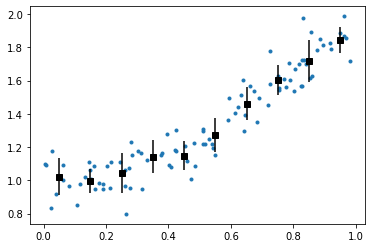

In [20]:
plt.scatter(x, y, marker=".")
plt.errorbar(profile.axes[0].centers, profile_view.value, profile_view.variance ** 0.5, fmt="sk");

You can now do a least-squares fit of this data, for example.

Note: ROOT offers [TProfile](https://root.cern/doc/v620/classTProfile.html), [TProfile2D](https://root.cern/doc/v620/classTProfile2D.html), and [TProfile3D](https://root.cern/doc/v620/classTProfile3D.html). With Boost-Histogram, you can make these and arbitrary higher-dimensional profiles.

### Advanced: Creative uses of profiles for fun and profit

Based on a real story!

Let's say you got a table with detector efficiencies in kinematic coordinates $(p, \eta)$ that you cannot produce yourself, but alas, your binning is in $(p_T, \eta)$. What to do? Fear not, Boost-Histogram comes to the rescue.

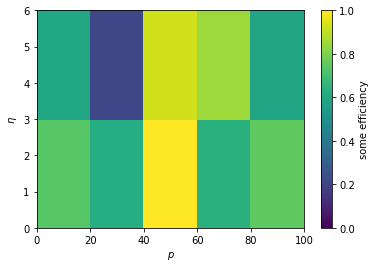

In [21]:
# make and plot a fake table in p, eta
rng = np.random.default_rng(2)

table = bh.Histogram(bh.axis.Regular(5, 0, 100, metadata="$p$"),
                     bh.axis.Regular(2, 0, 6, metadata=r"$\eta$"))
table.view()[:] = np.minimum(rng.normal(0.7, 0.2, size=(5, 2)), 1)

plt.pcolormesh(table.axes[0].edges, table.axes[1].edges, table.view().T)
plt.colorbar().set_label("some efficiency")
plt.xlabel(table.axes[0].metadata)
plt.ylabel(table.axes[1].metadata)
plt.clim(0, 1);

In [22]:
# the eta and pt values of your tracks
p = rng.uniform(0, 100, size=1000)
eta = rng.uniform(0, 6, size=1000)

In [23]:
# compute the efficieny values for each (pt, eta) coordinate
pt = p / (1 + np.sinh(eta) ** 2) ** 0.5

tab_view = table.view()
efficiencies = []
for k, m in zip(table.axes[0].index(p), table.axes[1].index(eta)):
    efficiencies.append(tab_view[(k, m)])

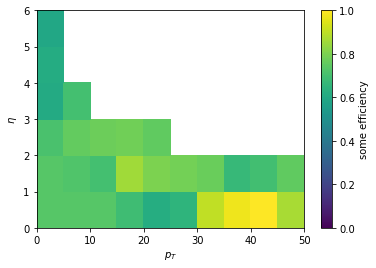

In [24]:
# and compute the correctly weighted efficiencies in your kinematic bins
my_table = bh.Histogram(bh.axis.Regular(10, 0, 50, metadata="$p_T$"),
                        bh.axis.Regular(6, 0, 6, metadata=r"$\eta$"),
                        storage=bh.storage.Mean())

my_table.fill(pt, eta, sample=efficiencies)
tview = my_table.view()

tab = np.ma.masked_array(tview.value, mask=tview.count ==0)
plt.pcolormesh(my_table.axes[0].edges, my_table.axes[1].edges, tab.T)
plt.xlabel(my_table.axes[0].metadata)
plt.ylabel(my_table.axes[1].metadata)
plt.colorbar().set_label("some efficiency")
plt.clim(0, 1);

## Making density histograms

Numpy has a keyword to compute a density estimate of some data set based on a histogram, like this. 

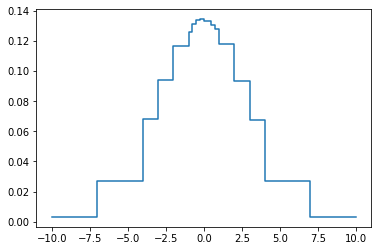

In [25]:
rng = np.random.default_rng(1)
data = rng.normal(0, 3, size=1_000_000)

# we use non-regular bin edges to show the effect of the density calculation
edges = [0, .25, .5, .75, 1, 2, 3, 4, 7, 10]
edges = [-x for x in reversed(edges)] + edges[1:]

n = np.histogram(data, bins=edges, density=True)[0]
plt.plot(edges, np.append(n, np.nan), drawstyle="steps-post");

It is easy to get the same result with Boost-Histogram.

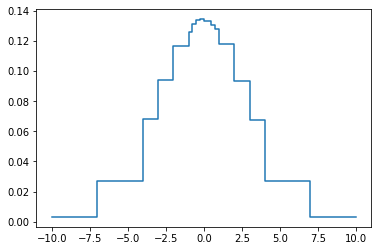

In [26]:
h = bh.Histogram(bh.axis.Variable(edges))
h.fill(data)
# equivalent one-liner: bh.numpy.histogram(data, bins=edges, histogram=bh.Histogram)

# normalize
h.view()[:] /= h.axes[0].widths * h.sum()

plt.plot(edges, np.append(h.view(), np.nan), drawstyle="steps-post");